![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Proyecto 2 - Clasificación de género de películas

El propósito de este proyecto es que puedan poner en práctica, en sus respectivos grupos de trabajo, sus conocimientos sobre técnicas de preprocesamiento, modelos predictivos de NLP, y la disponibilización de modelos. Para su desarrollo tengan en cuenta las instrucciones dadas en la "Guía del proyecto 2: Clasificación de género de películas"

**Entrega**: La entrega del proyecto deberán realizarla durante la semana 8. Sin embargo, es importante que avancen en la semana 7 en el modelado del problema y en parte del informe, tal y como se les indicó en la guía.

Para hacer la entrega, deberán adjuntar el informe autocontenido en PDF a la actividad de entrega del proyecto que encontrarán en la semana 8, y subir el archivo de predicciones a la [competencia de Kaggle](https://www.kaggle.com/t/2c54d005f76747fe83f77fbf8b3ec232).

## Datos para la predicción de género en películas

![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/moviegenre.png)

En este proyecto se usará un conjunto de datos de géneros de películas. Cada observación contiene el título de una película, su año de lanzamiento, la sinopsis o plot de la película (resumen de la trama) y los géneros a los que pertenece (una película puede pertenercer a más de un género). Por ejemplo:
- Título: 'How to Be a Serial Killer'
- Plot: 'A serial killer decides to teach the secrets of his satisfying career to a video store clerk.'
- Generos: 'Comedy', 'Crime', 'Horror'

La idea es que usen estos datos para predecir la probabilidad de que una película pertenezca, dada la sinopsis, a cada uno de los géneros.

Agradecemos al profesor Fabio González, Ph.D. y a su alumno John Arevalo por proporcionar este conjunto de datos. Ver https://arxiv.org/abs/1702.01992

## Ejemplo predicción conjunto de test para envío a Kaggle
En esta sección encontrarán el formato en el que deben guardar los resultados de la predicción para que puedan subirlos a la competencia en Kaggle.

In [78]:
import warnings
warnings.filterwarnings('ignore')

In [167]:
# Importación librerías
import pandas as pd
import os
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

In [80]:
# Carga de datos de archivo .csv
dataTraining = pd.read_csv('https://github.com/albahnsen/MIAD_ML_and_NLP/raw/main/datasets/dataTraining.zip', encoding='UTF-8', index_col=0)
dataTesting = pd.read_csv('https://github.com/albahnsen/MIAD_ML_and_NLP/raw/main/datasets/dataTesting.zip', encoding='UTF-8', index_col=0)

In [81]:
# Visualización datos de entrenamiento
dataTraining.head()

,year,title,plot,genres,rating
3107,2003,Most,most is the story of a single father who takes...,"['Short', 'Drama']",8.0
900,2008,How to Be a Serial Killer,a serial killer decides to teach the secrets o...,"['Comedy', 'Crime', 'Horror']",5.6
6724,1941,A Woman's Face,"in sweden , a female blackmailer with a disfi...","['Drama', 'Film-Noir', 'Thriller']",7.2
4704,1954,Executive Suite,"in a friday afternoon in new york , the presi...",['Drama'],7.4
2582,1990,Narrow Margin,"in los angeles , the editor of a publishing h...","['Action', 'Crime', 'Thriller']",6.6


In [82]:
# Visualización datos de test
dataTesting.head()

,year,title,plot
1,1999,Message in a Bottle,"who meets by fate , shall be sealed by fate ...."
4,1978,Midnight Express,"the true story of billy hayes , an american c..."
5,1996,Primal Fear,martin vail left the chicago da ' s office to ...
6,1950,Crisis,husband and wife americans dr . eugene and mr...
7,1959,The Tingler,the coroner and scientist dr . warren chapin ...


In [83]:
# Definición de variables predictoras (X)
vect = CountVectorizer(max_features=1000)
X_dtm = vect.fit_transform(dataTraining['plot'])
X_dtm.shape

(7895, 1000)

In [84]:
# Definición de variable de interés (y)
dataTraining['genres'] = dataTraining['genres'].map(lambda x: eval(x))
le = MultiLabelBinarizer()
y_genres = le.fit_transform(dataTraining['genres'])

In [85]:
# Separación de variables predictoras (X) y variable de interés (y) en set de entrenamiento y test usandola función train_test_split
X_train, X_test, y_train_genres, y_test_genres = train_test_split(X_dtm, y_genres, test_size=0.33, random_state=42)

In [86]:
# Definición y entrenamiento
clf = OneVsRestClassifier(RandomForestClassifier(n_jobs=-1, n_estimators=100, max_depth=10, random_state=42))
clf.fit(X_train, y_train_genres)

OneVsRestClassifier(estimator=RandomForestClassifier(max_depth=10, n_jobs=-1,
                                                     random_state=42))

In [87]:
# Predicción del modelo de clasificación
y_pred_genres = clf.predict_proba(X_test)

# Impresión del desempeño del modelo
roc_auc_score(y_test_genres, y_pred_genres, average='macro')

0.7812262183677007

In [88]:
# transformación variables predictoras X del conjunto de test
X_test_dtm = vect.transform(dataTesting['plot'])

cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

# Predicción del conjunto de test
y_pred_test_genres = clf.predict_proba(X_test_dtm)

In [89]:
# Guardar predicciones en formato exigido en la competencia de kaggle
res = pd.DataFrame(y_pred_test_genres, index=dataTesting.index, columns=cols)
res.to_csv('pred_genres_text_RF.csv', index_label='ID')
res.head()

,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,...,Musical,Mystery,News,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
1,0.143030,0.101960,0.024454,0.029938,0.354552,0.138830,0.030787,0.490140,0.073159,0.101339,...,0.025069,0.063208,0.000000,0.362818,0.056648,0.008970,0.017522,0.202605,0.033989,0.018117
4,0.122624,0.085786,0.024213,0.084795,0.370949,0.216657,0.080359,0.515684,0.062976,0.067019,...,0.024734,0.060935,0.000477,0.149703,0.058190,0.014248,0.020099,0.204794,0.030438,0.018506
5,0.151364,0.110284,0.013762,0.075334,0.304837,0.448736,0.021010,0.611544,0.081741,0.169121,...,0.044538,0.261372,0.000000,0.335987,0.128505,0.001016,0.048658,0.423242,0.052693,0.025351
6,0.154448,0.125772,0.020991,0.064124,0.340779,0.140892,0.009133,0.632038,0.068287,0.063631,...,0.131074,0.088418,0.000000,0.197224,0.132208,0.001432,0.039743,0.269385,0.077607,0.017862
7,0.175143,0.210069,0.035476,0.032505,0.313850,0.243150,0.021793,0.427885,0.079781,0.143879,...,0.023859,0.090359,0.000048,0.205117,0.241663,0.002634,0.018403,0.259465,0.021569,0.017585


<h1>Preprocesamiento</h1>

1. Generar dummies de las variables 

In [277]:
# Importación librerías
!pip install livelossplot
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Dropout,TextVectorization
from keras import backend as K
from livelossplot import PlotLossesKeras
from keras.callbacks import EarlyStopping
from keras.preprocessing import sequence
import keras
from tensorflow.keras.layers import LSTM,Dense, Dropout, Embedding
from xgboost import XGBClassifier

In [23]:
# Carga de datos de archivo .csv
dataTraining = pd.read_csv('https://github.com/albahnsen/MIAD_ML_and_NLP/raw/main/datasets/dataTraining.zip', encoding='UTF-8', index_col=0)
dataTesting = pd.read_csv('https://github.com/albahnsen/MIAD_ML_and_NLP/raw/main/datasets/dataTesting.zip', encoding='UTF-8', index_col=0)

In [313]:
#Definicion de las funciones transformadoras
# def X_processing(dataTraining, dataTesting):
#     vect = CountVectorizer(max_features=1000)
#     X_train_dtm = vect.fit_transform(dataTraining['plot'])
#     X_test_dtm = vect.transform(dataTesting['plot'])
#     return X_train_dtm, X_test_dtm


def X_processing(dataTraining, dataTesting):
    np.random.seed(42)
    vect = CountVectorizer(max_features=1000, stop_words='english')
    X_train_dtm = vect.fit_transform(dataTraining['plot'])
    X_test_dtm = vect.transform(dataTesting['plot'])
    return X_train_dtm, X_test_dtm

def X_processing2(dataTraining, dataTesting):
    vectorizer = TextVectorization(standardize="lower_and_strip_punctuation", output_mode='int')
    vectorizer.adapt(dataTraining['plot'])
    X_train_dtm = vectorizer(dataTraining['plot'])
    X_test_dtm = vectorizer(dataTesting['plot'])
    return X_train_dtm, X_test_dtm

def X_processing3(dataset):
    X = dataset['plot'].tolist()
    voc = set(''.join(X))
    vocabulary = {x: idx + 1 for idx, x in enumerate(set(voc))}
    # Definición máximo largo de embedding
    max_des_len = 1500
    # Codificación (embedding) de la URL con el vocabulario definido anteriormente
    X = [x[:max_des_len] for x in X]
    X = [[vocabulary[x1] for x1 in x if x1 in vocabulary.keys()] for x in X]
    print(len(vocabulary))
    return sequence.pad_sequences(X, maxlen=max_des_len)



def y_processing(dataTraining):
    dataTraining['genres'] = dataTraining['genres'].map(lambda x: eval(x))
    le = MultiLabelBinarizer()
    y_genres = le.fit_transform(dataTraining['genres'])
    return y_genres

def modelo1(X_train, X_test, y_train, y_test):
    K.clear_session()
    np.random.seed(42)
    keras.utils.set_random_seed(42)
    input=1500
    output = y_train.shape[1]
    adam = optimizers.Adam(learning_rate=0.001)

    # Crear el modelo
    model = Sequential()
    model.add(Dense(512, input_shape=(input,)))
    model.add(Dropout(0.1))
    model.add(Dense(256, activation='sigmoid'))
    model.add(Dropout(0.1))
    model.add(Dense(output, activation='sigmoid'))  # Multilabel output
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['AUC'])
    early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1) 
    model.fit(X_train, y_train,
        verbose=1,
        epochs=1000,
        batch_size=72,
        validation_data=(X_test, y_test),
        callbacks=[PlotLossesKeras(),early_stop])
    pred=model.predict(X_test)
    auc=roc_auc_score(y_test, pred, average='macro')
    print(f'resultado modelo, AUC={auc}')
    return model

def modelo2(X_train, X_test, y_train, y_test):
  K.clear_session()
  np.random.seed(42)
  keras.utils.set_random_seed(42)

  input = X_train.shape[1]
  output = y_train.shape[1]
  adam=optimizers.Adam( learning_rate=0.001)

  model = Sequential()
  model.add(Dense(256, input_shape=(input,)))
  model.add(Dropout(0.1))
  model.add(Dense(512, activation='sigmoid'))
  model.add(Dropout(0.1))
  model.add(Dense(output, activation='sigmoid'))  # Multilabel output
  model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['AUC'])
  X_train = X_train.toarray()
  X_test = X_test.toarray()
  early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1) 
  model.fit(X_train, y_train,
    verbose=1,
    epochs=1000,
    batch_size=input,
    validation_data=(X_test, y_test),
    callbacks=[PlotLossesKeras(),early_stop])
  pred=model.predict(X_test)
  auc=roc_auc_score(y_test, pred, average='macro')
  print(f'resultado modelo, AUC={auc}')
  return model

def modelo3(X_train, X_test, y_train, y_test):
    K.clear_session()
    np.random.seed(42)
    keras.utils.set_random_seed(42)

    input = X_train.shape[1]
    output = y_train.shape[1]
    adam=optimizers.Adam( learning_rate=0.005)
    # Definición red neuronal con la función Sequential()
    model = Sequential()
    model.add(Embedding(1,256))
    model.add(Dropout(0.1))
    model.add(LSTM(512,activation="sigmoid" ))
    model.add(Dropout(0.1))
    model.add(Dense(output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['AUC'])
    X_train = X_train.toarray()
    X_test = X_test.toarray()
    model.fit(X_train, y_train,
        verbose=1,
        epochs=10,
        batch_size=input,
        validation_data=(X_test, y_test),
        callbacks=[PlotLossesKeras()])
    pred=model.predict(X_test)
    auc=roc_auc_score(y_test, pred, average='macro')
    print(f'resultado modelo, AUC={auc}')
    return model

def modelo4(X_train, X_test, y_train, y_test):
    models = []
    for i in range(y_train.shape[1]):
        model = XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, objective='binary:logistic')
        model.fit(X_train, y_train[:, i])
        models.append(model)
    y_pred = np.zeros(y_test.shape)
    for i, model in enumerate(models):
        y_pred[:, i] = model.predict(X_test)
    auc=roc_auc_score(y_test, y_pred, average='macro')
    print(f'resultado modelo, AUC={auc}')
    return models

def prediccion(model, X_test_dtm):
    cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']
    y_pred_test_genres = model.predict(X_test_dtm.toarray())
    res = pd.DataFrame(y_pred_test_genres, index=dataTesting.index, columns=cols)
    res.to_csv('pred_genres_text_RF.csv', index_label='ID')
    return '100%'

def prediccion2(model, X_test_dtm):
    
    cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']
    res = pd.DataFrame(index=dataTesting.index, columns=cols)
    for i, m in enumerate(model):
        res[cols[i]] = m.predict_proba(X_test_dtm.toarray())
    res.to_csv('pred_genres_text_RF.csv', index_label='ID')

<h1>Modelo 1</h1>

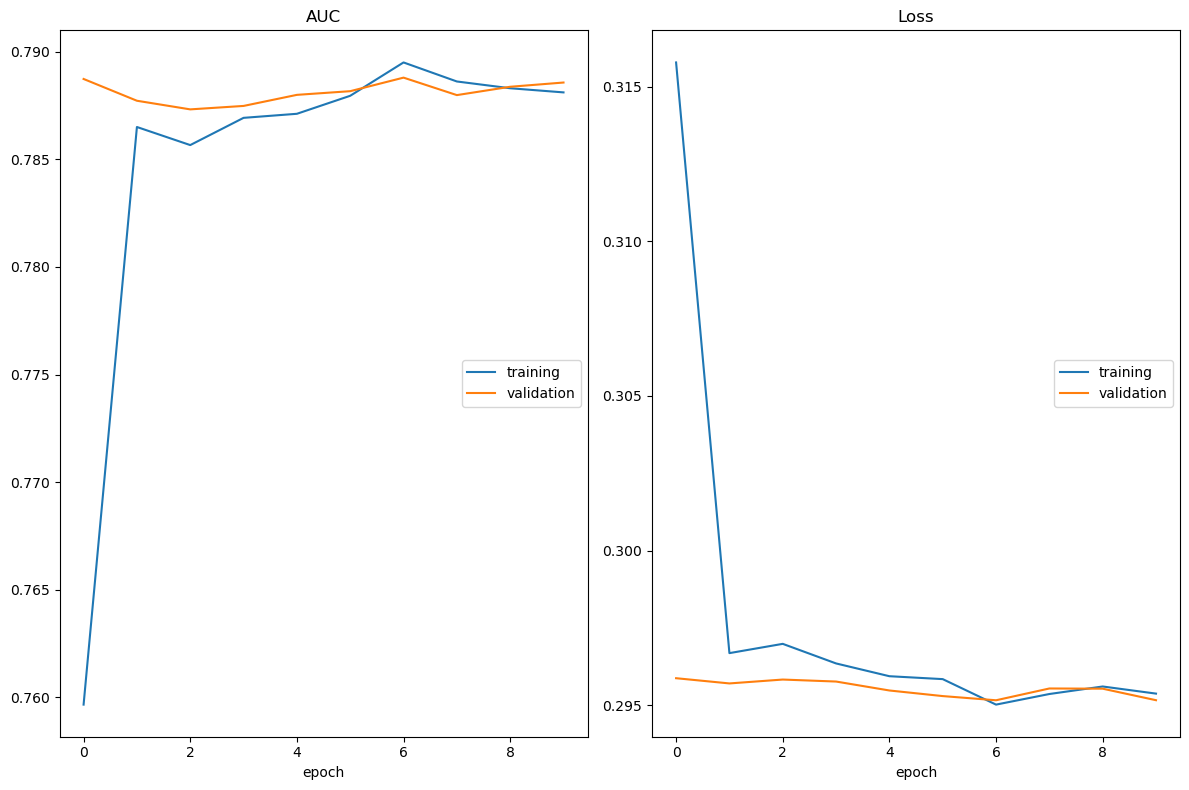

AUC
	training         	 (min:    0.760, max:    0.790, cur:    0.788)
	validation       	 (min:    0.787, max:    0.789, cur:    0.789)
Loss
	training         	 (min:    0.295, max:    0.316, cur:    0.295)
	validation       	 (min:    0.295, max:    0.296, cur:    0.295)
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - AUC: 0.7877 - loss: 0.2962 - val_AUC: 0.7886 - val_loss: 0.2952
Epoch 10: early stopping
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
resultado modelo, AUC=0.5217004679693003


In [300]:
#Procesa variables X y y
df_train = dataTraining.copy()
df_test = dataTesting.copy()
X_train_dtm= X_processing3(df_train) 
X_test_dtm= X_processing3(df_test) 
y=y_processing(df_train)

X_train, X_test, y_train, y_test = train_test_split(X_train_dtm, y, test_size=0.33, random_state=42)

modelo=modelo1(X_train, X_test, y_train, y_test)

# prediccion(modelo, X_test_dtm)

<h2>Modelo 2</h2>

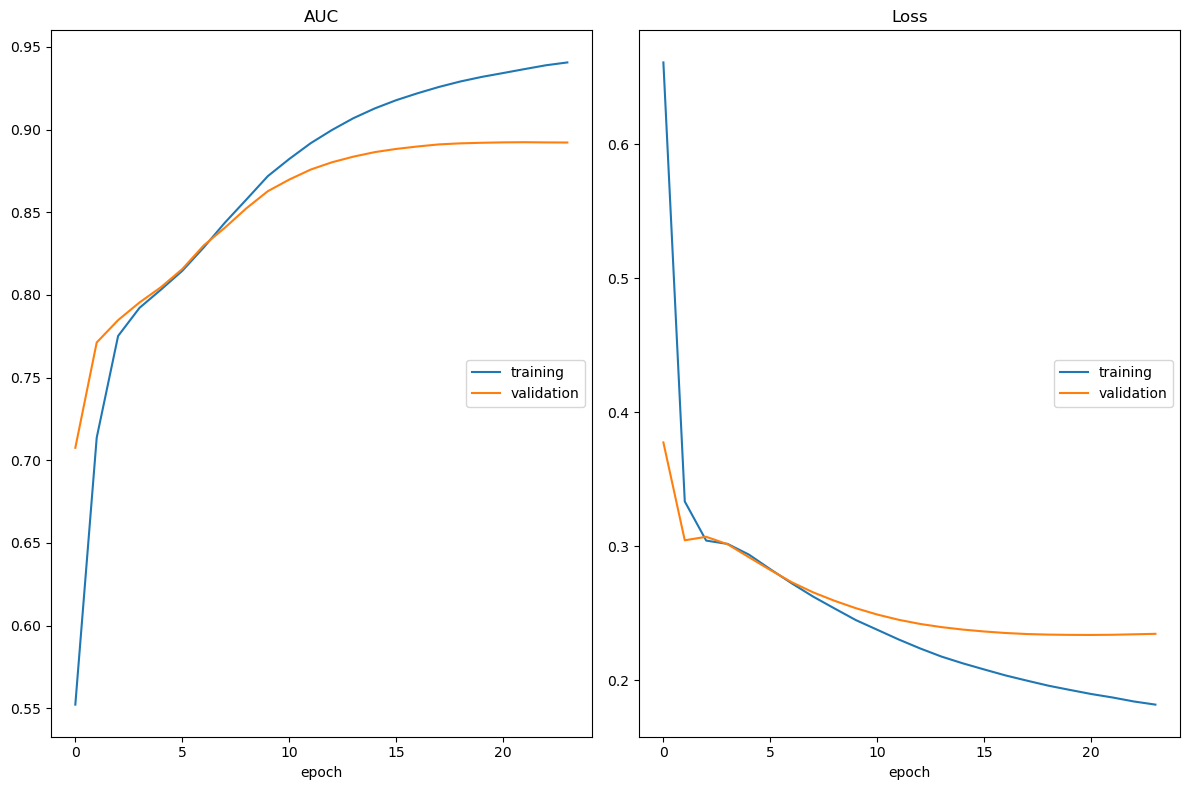

AUC
	training         	 (min:    0.552, max:    0.941, cur:    0.941)
	validation       	 (min:    0.708, max:    0.892, cur:    0.892)
Loss
	training         	 (min:    0.182, max:    0.661, cur:    0.182)
	validation       	 (min:    0.234, max:    0.378, cur:    0.235)
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - AUC: 0.9389 - loss: 0.1837 - val_AUC: 0.8922 - val_loss: 0.2346
Epoch 24: early stopping
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
resultado modelo, AUC=0.8312179505657123


In [311]:
#Procesa variables X y y
df_train = dataTraining.copy()
df_test = dataTesting.copy()
X_train_dtm, X_test_dtm = X_processing(df_train, df_test)
y=y_processing(df_train)

X_train, X_test, y_train, y_test = train_test_split(X_train_dtm, y, test_size=0.33, random_state=42)

modelo=modelo2(X_train, X_test, y_train, y_test)
# prediccion(modelo, X_test_dtm)

<h2>Modelo 3</h2>

In [314]:
#Procesa variables X y y
df_train = dataTraining.copy()
df_test = dataTesting.copy()
X_train_dtm, X_test_dtm = X_processing(df_train, df_test)
y=y_processing(df_train)

X_train, X_test, y_train, y_test = train_test_split(X_train_dtm, y, test_size=0.33, random_state=42)

modelo=modelo3(X_train, X_test, y_train, y_test)
# prediccion(modelo, X_test_dtm)

Epoch 1/10


InvalidArgumentError: Graph execution error:

Detected at node sequential_1/embedding_1/GatherV2 defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\arcil\AppData\Roaming\Python\Python312\site-packages\ipykernel_launcher.py", line 18, in <module>

  File "C:\Users\arcil\AppData\Roaming\Python\Python312\site-packages\traitlets\config\application.py", line 1075, in launch_instance

  File "C:\Users\arcil\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelapp.py", line 739, in start

  File "C:\Users\arcil\AppData\Roaming\Python\Python312\site-packages\tornado\platform\asyncio.py", line 205, in start

  File "c:\Users\arcil\miniconda3\Lib\asyncio\base_events.py", line 639, in run_forever

  File "c:\Users\arcil\miniconda3\Lib\asyncio\base_events.py", line 1985, in _run_once

  File "c:\Users\arcil\miniconda3\Lib\asyncio\events.py", line 88, in _run

  File "C:\Users\arcil\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue

  File "C:\Users\arcil\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelbase.py", line 534, in process_one

  File "C:\Users\arcil\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell

  File "C:\Users\arcil\AppData\Roaming\Python\Python312\site-packages\ipykernel\ipkernel.py", line 362, in execute_request

  File "C:\Users\arcil\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelbase.py", line 778, in execute_request

  File "C:\Users\arcil\AppData\Roaming\Python\Python312\site-packages\ipykernel\ipkernel.py", line 449, in do_execute

  File "C:\Users\arcil\AppData\Roaming\Python\Python312\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "C:\Users\arcil\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell

  File "C:\Users\arcil\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell

  File "C:\Users\arcil\AppData\Roaming\Python\Python312\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "C:\Users\arcil\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async

  File "C:\Users\arcil\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes

  File "C:\Users\arcil\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code

  File "C:\Users\arcil\AppData\Local\Temp\ipykernel_38128\1628208794.py", line 9, in <module>

  File "C:\Users\arcil\AppData\Local\Temp\ipykernel_38128\846075810.py", line 119, in modelo3

  File "c:\Users\arcil\miniconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\arcil\miniconda3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 314, in fit

  File "c:\Users\arcil\miniconda3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 117, in one_step_on_iterator

  File "c:\Users\arcil\miniconda3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 104, in one_step_on_data

  File "c:\Users\arcil\miniconda3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 51, in train_step

  File "c:\Users\arcil\miniconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\arcil\miniconda3\Lib\site-packages\keras\src\layers\layer.py", line 846, in __call__

  File "c:\Users\arcil\miniconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\arcil\miniconda3\Lib\site-packages\keras\src\ops\operation.py", line 48, in __call__

  File "c:\Users\arcil\miniconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "c:\Users\arcil\miniconda3\Lib\site-packages\keras\src\models\sequential.py", line 209, in call

  File "c:\Users\arcil\miniconda3\Lib\site-packages\keras\src\models\functional.py", line 202, in call

  File "c:\Users\arcil\miniconda3\Lib\site-packages\keras\src\ops\function.py", line 155, in _run_through_graph

  File "c:\Users\arcil\miniconda3\Lib\site-packages\keras\src\models\functional.py", line 592, in call

  File "c:\Users\arcil\miniconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\arcil\miniconda3\Lib\site-packages\keras\src\layers\layer.py", line 846, in __call__

  File "c:\Users\arcil\miniconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\arcil\miniconda3\Lib\site-packages\keras\src\ops\operation.py", line 48, in __call__

  File "c:\Users\arcil\miniconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "c:\Users\arcil\miniconda3\Lib\site-packages\keras\src\layers\core\embedding.py", line 146, in call

  File "c:\Users\arcil\miniconda3\Lib\site-packages\keras\src\ops\numpy.py", line 4850, in take

  File "c:\Users\arcil\miniconda3\Lib\site-packages\keras\src\backend\tensorflow\numpy.py", line 1940, in take

indices[937,789] = 1 is not in [0, 1)
	 [[{{node sequential_1/embedding_1/GatherV2}}]] [Op:__inference_one_step_on_iterator_807742]

<h1>Modelo 4</h1>

In [315]:
#Procesa variables X y y
df_train = dataTraining.copy()
df_test = dataTesting.copy()
X_train_dtm, X_test_dtm = X_processing(df_train, df_test)
y=y_processing(df_train)

X_train, X_test, y_train, y_test = train_test_split(X_train_dtm, y, test_size=0.33, random_state=42)

modelo=modelo4(X_train, X_test, y_train, y_test)
# prediccion2(modelo, X_test_dtm)

resultado modelo, AUC=0.5641810880257525
